In [1]:
#Importing necessary libraries
import numpy as np
import pandas as pd
import geopandas as gpd
from osgeo import gdal
import matplotlib.pyplot as plt 

In [2]:
#Setting path variables to our input and output files
inp_ras_path="C:\\Summer2022\\Marginal-Land-Classification\\Palakkad_Supervised_Landsat\\Data_Preprocessing\\New_Palakkad_Raster.tif"
inp_data_xlsx="C:\\Summer2022\\Marginal-Land-Classification\\Palakkad_Supervised_Landsat\\Data_Preprocessing\\Train_Palakkad.xlsx"
output_raster="C:\\Summer2022\\Marginal-Land-Classification\\Palakkad_Supervised_Landsat\\Classified_Results_Supervised\\SVC.tif"

In [3]:
#Reading the dataset
df=pd.read_excel(inp_data_xlsx)
df.head()

,Unnamed: 0,Name,Shape_Leng,Shape_Area,geometry,band1,band2,band3,band4,band5,band6
0,0,St,0.002974,4.866600e-07,POINT (76.64307164300004 10.788226620000046),654.013916,858.013916,944.013916,2036.513916,2422.013916,2185.013916
1,1,St,0.002974,4.866600e-07,POINT (76.64277901900005 10.78838195000003),609.496826,835.496826,869.996826,2122.496826,2043.496826,1787.996826
2,2,St,0.002974,4.866600e-07,POINT (76.64298855100003 10.788809429000025),734.508606,1019.008606,1162.008545,2219.008545,2567.508545,2153.508545
3,3,St,0.002974,4.866600e-07,POINT (76.64307477100004 10.788927469000043),734.508606,1019.008606,1162.008545,2219.008545,2567.508545,2153.508545
4,4,St,0.002974,4.866600e-07,POINT (76.64321036300004 10.788880423000023),845.011780,1124.011841,1210.511841,2114.011719,2666.511719,2429.011719


In [4]:
#Removing the column which is not required
df=df.drop(['Unnamed: 0'],axis=1)
df.head()

,Name,Shape_Leng,Shape_Area,geometry,band1,band2,band3,band4,band5,band6
0,St,0.002974,4.866600e-07,POINT (76.64307164300004 10.788226620000046),654.013916,858.013916,944.013916,2036.513916,2422.013916,2185.013916
1,St,0.002974,4.866600e-07,POINT (76.64277901900005 10.78838195000003),609.496826,835.496826,869.996826,2122.496826,2043.496826,1787.996826
2,St,0.002974,4.866600e-07,POINT (76.64298855100003 10.788809429000025),734.508606,1019.008606,1162.008545,2219.008545,2567.508545,2153.508545
3,St,0.002974,4.866600e-07,POINT (76.64307477100004 10.788927469000043),734.508606,1019.008606,1162.008545,2219.008545,2567.508545,2153.508545
4,St,0.002974,4.866600e-07,POINT (76.64321036300004 10.788880423000023),845.011780,1124.011841,1210.511841,2114.011719,2666.511719,2429.011719


In [5]:
#Using LabelEncoder to assign integer values to classes in order to train our model
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
num_categories=le.fit_transform(df['Name'])
df['Number_Name']=num_categories
df.head()

,Name,Shape_Leng,Shape_Area,geometry,band1,band2,band3,band4,band5,band6,Number_Name
0,St,0.002974,4.866600e-07,POINT (76.64307164300004 10.788226620000046),654.013916,858.013916,944.013916,2036.513916,2422.013916,2185.013916,3
1,St,0.002974,4.866600e-07,POINT (76.64277901900005 10.78838195000003),609.496826,835.496826,869.996826,2122.496826,2043.496826,1787.996826,3
2,St,0.002974,4.866600e-07,POINT (76.64298855100003 10.788809429000025),734.508606,1019.008606,1162.008545,2219.008545,2567.508545,2153.508545,3
3,St,0.002974,4.866600e-07,POINT (76.64307477100004 10.788927469000043),734.508606,1019.008606,1162.008545,2219.008545,2567.508545,2153.508545,3
4,St,0.002974,4.866600e-07,POINT (76.64321036300004 10.788880423000023),845.011780,1124.011841,1210.511841,2114.011719,2666.511719,2429.011719,3


In [6]:
#Segregate the columns required for classification i.e independent variables
train_labels=df[['band1','band2','band3','band4','band5','band6']]
#Selecting the dependent label
dep_label=df['Number_Name']

In [7]:
#Using gdal to read the raster file and get properties
raster=gdal.Open(inp_ras_path)
r=raster.RasterYSize
c=raster.RasterXSize
geotransform=raster.GetGeoTransform()
proj=raster.GetProjectionRef()
ras_arr=raster.ReadAsArray()
num_bands=raster.RasterCount
#printing first element of ras_arr just to get an idea
ras_arr[0]

array([[302.36493, 336.91345, 348.9318 , ..., 138.74207, 138.73117,
        140.21135],
       [309.90854, 313.42224, 294.9218 , ..., 139.72775, 133.20668,
        136.19824],
       [312.889  , 314.93445, 297.92996, ..., 131.70714, 131.69638,
        133.19931],
       ...,
       [449.94327, 399.9475 , 403.49487, ..., 366.93008, 357.9387 ,
        453.47867],
       [369.39   , 363.39368, 401.98032, ..., 374.38577, 409.3952 ,
        411.41776],
       [350.9251 , 356.40097, 390.44278, ..., 471.44406, 539.4624 ,
        500.4569 ]], dtype=float32)

In [8]:
#Changing the shape of array so that it can be fed into the model
ras_arr=np.stack(ras_arr,axis=2)
ras_arr=np.reshape(ras_arr,[r*c,num_bands])
dataset=pd.DataFrame(ras_arr)
dataset.head()

,0,1,2,3,4,5
0,302.364929,537.864929,401.364929,2980.864990,1630.364868,826.364929
1,336.913452,596.413452,493.913452,2714.413574,1711.913452,991.413452
2,348.931793,609.431763,528.431763,2471.431885,1623.931763,986.931763
3,291.872223,535.872253,416.372223,2749.872314,1429.372192,725.872253
4,306.911499,568.911499,487.411499,2853.911377,1844.911499,980.911499


In [9]:
#Splitting the dataset in 80:20 ratio
from sklearn.model_selection import train_test_split
train_data,test_data=train_test_split(df,test_size=0.2,random_state=25)
x_train=train_data[['band1','band2','band3','band4','band5','band6']]
y_train=train_data['Number_Name']
x_test=test_data[['band1','band2','band3','band4','band5','band6']]
y_test=test_data['Number_Name']

In [10]:
from sklearn import svm
clf = svm.SVC()
clf.fit(x_train,y_train)

SVC()

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
from sklearn.metrics import classification_report
y_pred=clf.predict(x_test)
print(accuracy_score(y_test, y_pred))

0.8


In [12]:
clf_res=clf.predict(dataset)
res=clf_res.reshape((r,c))
# #Extracting the results to a tif file
drv=gdal.GetDriverByName("GTiff")
drv.Register()
clf_pal=drv.Create(output_raster,c,r,bands=1,eType=gdal.GDT_Int32)
clf_pal.SetGeoTransform(geotransform)
clf_pal.SetProjection(proj)
clf_pal.GetRasterBand(1).WriteArray(res)
clf_pal.FlushCache()
clf_pal=None 

C:\Users\Student\miniconda3\envs\earth-analytics-python\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.73      0.94      0.82        65
           1       0.29      0.09      0.14        22
           2       0.65      0.93      0.76        45
           3       0.90      0.75      0.81        59
           4       0.85      0.86      0.86        81
           5       1.00      0.78      0.88        63

    accuracy                           0.80       335
   macro avg       0.74      0.73      0.71       335
weighted avg       0.80      0.80      0.79       335



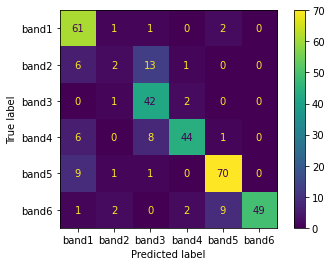

In [13]:
cf=confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cf,
                               display_labels=['band1','band2','band3','band4','band5','band6'])
disp.plot()
print(classification_report(y_test,y_pred))